# Structural Patterns

The creational patterns are guidelines suggested to compose objects in a way that allows to perform new functionalities. Those new functionalities would be harder to do without the new class/function created.

The structural patterns at the same time allows dealing with across entities relationships in an easier and managable way.

In simple words: **How to compose complex objects**

The seven structural patterns available are:
1. Adapter
2. Bridge
3. Composite
4. Decorator
5. Facade
6. Flyweight
7. Proxy

Each of those previous patterns are unique, and can be used in different situations and conditions.

# Decorator

**What is the decorator?**

A decorator gives superpowers to existing classes. What do I mean? It does not modify current or existing classes, it adds more capabilities to the classes that already exists.

**When should we use it?**

This pattern is suitable when have common actions that are repeated across different objects that you're creating. For the MLE context, it can be used for data reviewing, logs, mlflow - weigths and biases registry, or caching some actions.

**Warning:**

Is this `decorator` the same as the `@decorator` available in Python?

Yes and no. It provides the same functionality, I mean both aims to provide additional capabilities to an existing entity, but the `decorator` class comes from the GoF book. Their original idea was an additional class. Thus, throughout this notebook the decorator definition will be based on the GoF book.

**Analogy:**

When someone wants to wear some clothes, you don't need to create a single object for each possible entity scenario. The most suitable approach, it's to decorate you're object and adding the additional functionalities (in this case the clothes).

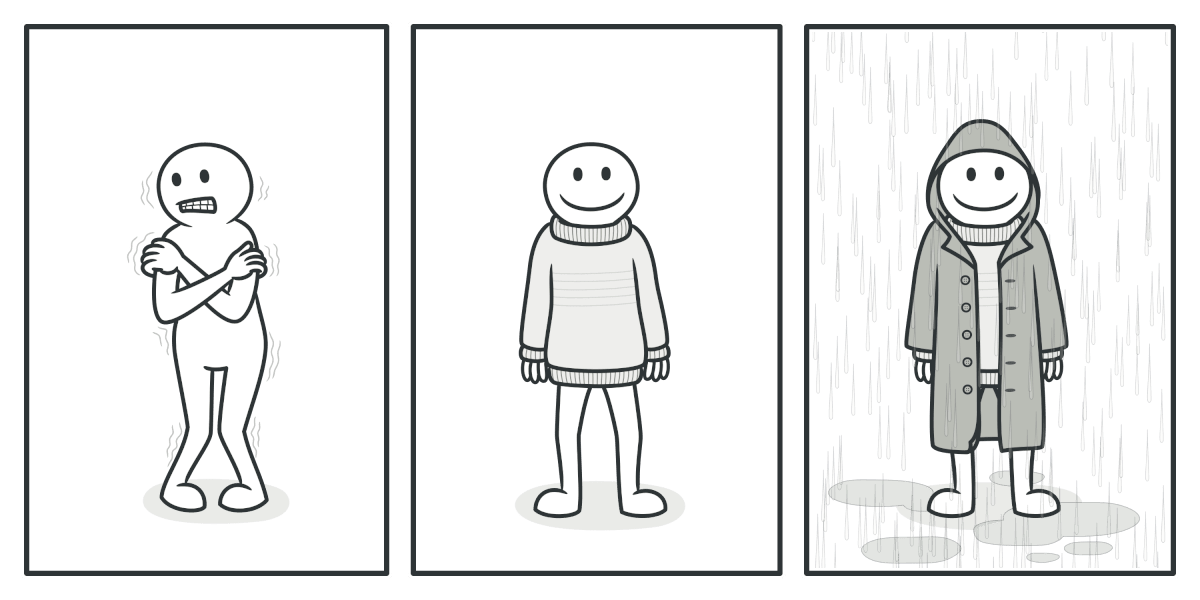

Reference: https://refactoring.guru/design-patterns/decorator

**Scenario**

You need to need to validate all data given for a model training. The requirements are:

1. Verify there is no strings in the data

2. Data is normalized between 0 to 1.

3. Verify all columns are ints or floats.

4. Validate no missing values.

Load some toy dataset

In [16]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor

In [17]:
df = load_diabetes(as_frame=True, return_X_y=True)

In [18]:
df = pd.concat([df[0], df[1]], axis=1)

In [19]:
scaler = MinMaxScaler()

In [20]:
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Make an split for train-test

In [21]:
y = df["target"]
x = df.drop(["target"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=99
)

## Antipattern

The antipattern is quite easy to create. If you're a novice ML Eng, you might be thinking about creating a single function to validate all data before we start the training loop.

In [22]:
def validate_string(df):
    """
    Function to review if there are strings in the dataframe.
    """
    string_columns = df.select_dtypes(include=["object"]).columns
    if len(string_columns) > 0:
        raise ValueError(
            f"DataFrame contains string columns: {string_columns.tolist()}"
        )


def validate_normalized_data(df):
    """
    This function checks if all columns in the dataframe are normalized between 0 and 1.
    """
    for column in df.columns:
        if not ((df[column] >= 0).all() and (df[column] <= 1).all()):
            raise ValueError(f"Column '{column}' is not normalized between 0 and 1.")


def verify_int_floats(df):
    """
    Function to verify if all columns are either integers or floats.
    """
    target_columns = df.select_dtypes(include=["int64", "float64"]).columns
    if len(target_columns) != len(df.columns):
        raise ValueError("DataFrame contains non-numeric columns.")


def verify_null_values(df):
    """
    Function to verify if there are any null values in the dataframe.
    """
    if df.isnull().values.any():
        raise ValueError("DataFrame contains null values.")

So everytime we want to train the model, we will need to invoke those functions

In [23]:
validate_string(x_train)
validate_normalized_data(x_train)
verify_int_floats(x_train)
verify_null_values(x_train)

In [25]:
model1 = RandomForestRegressor()
model1.fit(x_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
y_pred1 = model1.predict(x_test)

Problems with this? 

Again, we fall into the hole of DRY. Everytime we want the validation, we need to call the functions. How to avoid this? We can overcome this applying the `decorator` design pattern.

## Pattern

The `decorator` is just a class that keeps almost all the same, it just adds the additional functionality.

In [32]:
class DataValidator:
    def __init__(self, model):
        self.model = model

    def fit(self, x_train: pd.DataFrame, y_train: pd.DataFrame) -> None:
        self.validate_string(x_train)
        self.validate_normalized_data(x_train)
        self.verify_int_floats(x_train)
        self.verify_null_values(x_train)
        print("Data validation passed. Proceeding to fit the model.")
        self.model.fit(x_train, y_train)

    def predict(self, df: pd.DataFrame) -> np.ndarray:
        return self.model.predict(df)

    def validate_string(self, df: pd.DataFrame):
        """
        Function to review if there are strings in the dataframe.
        """
        string_columns = df.select_dtypes(include=["object"]).columns
        if len(string_columns) > 0:
            raise ValueError(
                f"DataFrame contains string columns: {string_columns.tolist()}"
            )

    def validate_normalized_data(self, df: pd.DataFrame):
        """
        This function checks if all columns in the dataframe are normalized between 0 and 1.
        """
        for column in df.columns:
            if not ((df[column] >= 0).all() and (df[column] <= 1).all()):
                raise ValueError(
                    f"Column '{column}' is not normalized between 0 and 1."
                )

    def verify_int_floats(self, df: pd.DataFrame):
        """
        Function to verify if all columns are either integers or floats.
        """
        target_columns = df.select_dtypes(include=["int64", "float64"]).columns
        if len(target_columns) != len(df.columns):
            raise ValueError("DataFrame contains non-numeric columns.")

    def verify_null_values(self, df: pd.DataFrame):
        """
        Function to verify if there are any null values in the dataframe.
        """
        if df.isnull().values.any():
            raise ValueError("DataFrame contains null values.")

Now, instead of defining the model class directly, we will define the decorator class

In [33]:
rf_decorated = DataValidator(RandomForestRegressor())

In [34]:
rf_decorated.fit(x_train, y_train)

Data validation passed. Proceeding to fit the model.


In [35]:
y_pred2 = rf_decorated.predict(x_test)

Finally, as you saw previously, the decorator class allowed to perform the data validation without additional effort of calling again the functions. But the actual question that comes into the mind is? Is this actually applicable into a new model type?

Short answer: Yes

Long answer: Yes, indeed.

Let's try with a Linear Regression model

In [36]:
from sklearn.linear_model import LinearRegression

In [38]:
linear_reg_decorated = DataValidator(LinearRegression())

In [39]:
linear_reg_decorated.fit(x_train, y_train)

Data validation passed. Proceeding to fit the model.


In [40]:
y_pred3 = linear_reg_decorated.predict(x_test)

Again, as you saw previously this is the magic things that we can get from the `decorator`, we added additional funtionalities without falling into the DRY.